In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.tsa.api as smt

from pandas.plotting import autocorrelation_plot
from statsmodels.graphics.gofplots import qqplot
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf, pacf, adfuller
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from arch import arch_model
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR

import warnings
warnings.filterwarnings("ignore")

# Data

In [2]:
#Read the stock data of Costco
df = pd.read_csv('COST 3.csv', parse_dates=['Date'], index_col='Date').dropna().drop("Open", axis=1).drop("High",axis=1).drop("Low",axis=1).drop("Adj Close",axis=1)
df['Return'] = df['Close'].pct_change()
df=df.dropna()

## Stationarity

In [3]:
from statsmodels.tsa.stattools import adfuller

# Assuming `df['Close']` is your time series data
result = adfuller(df['Return'], autolag='AIC')  # AIC stands for Akaike Information Criterion

# The result is a tuple of statistics from the test
adf_stat, p_value, usedlag, nobs, critical_values, icbest = result

print(f"ADF Statistic: {adf_stat}")
print(f"p-value: {p_value}")

# Interpretation based on p-value
if p_value <= 0.05:
    print("The series is likely stationary.")
else:
    print("The series is likely non-stationary.")

ADF Statistic: -27.231867771895725
p-value: 0.0
The series is likely stationary.


In [4]:
plt.hist(r)
# Nice!

NameError: name 'r' is not defined

## Data Combination

In [5]:
#Add External Factors

#Walmart
df1 = pd.read_csv('WMT.csv', parse_dates=['Date'], index_col='Date').dropna().drop("Open", axis=1).drop("High",axis=1).drop("Low",axis=1).drop("Adj Close",axis=1).drop("Volume",axis=1)
df1['Walmart Return'] = df1['Close'].pct_change()
df1=df1.dropna().drop("Close", axis=1)
s = 1978  
# Fix data on most recent 3 years -- We have tested 10 year, 5 years and 2019-2023 and 3 years. And 3-year data perform the best.
df1 = df1.iloc[s:]


#Target
df2 = pd.read_csv('TGT.csv', parse_dates=['Date'], index_col='Date').dropna().drop("Open", axis=1).drop("High",axis=1).drop("Low",axis=1).drop("Adj Close",axis=1).drop("Volume",axis=1)
df2['Target Return'] = df2['Close'].pct_change()
df2=df2.dropna().drop("Close", axis=1)
df2 = df2.iloc[s:]

# Amazon
df3 = pd.read_csv('AMZN.csv', parse_dates=['Date'], index_col='Date').dropna().drop("Open", axis=1).drop("High",axis=1).drop("Low",axis=1).drop("Adj Close",axis=1).drop("Volume",axis=1)
df3['Amazon Return'] = df3['Close'].pct_change()
df3=df3.dropna().drop("Close", axis=1)
df3 = df3.iloc[s:]

#DJIA
df4 = pd.read_csv('DJIA.csv', parse_dates=['Date'], index_col='Date').drop("Open", axis=1).drop("High",axis=1).drop("Low",axis=1).drop("Change %",axis=1).drop("Vol.",axis=1)
df4 = df4.replace({',': ''}, regex=True)
df4['Price'] = pd.to_numeric(df4['Price'], errors='coerce')
df4['DJIA Return'] = df4['Price'].pct_change()
df4=df4.dropna().drop("Price", axis=1)
df4 = df4.iloc[s:]

#SP500 
df5 = pd.read_csv('SPX.csv', parse_dates=['Date'], index_col='Date').drop("Open", axis=1).drop("High",axis=1).drop("Low",axis=1).drop("Change %",axis=1).drop("Vol.",axis=1)
df5 = df5.replace({',': ''}, regex=True)
df5['Price'] = pd.to_numeric(df5['Price'], errors='coerce')
df5['S&P500 return'] = df5['Price'].pct_change()
df5=df5.dropna().drop("Price", axis=1)
df5 = df5.iloc[s:]

#interest rate
df6 = pd.read_csv('interest rate.csv', parse_dates=['Date'], index_col='Date')
columns_to_drop = df6.columns.drop('Rate (%)')
df6 = df6.drop(columns=columns_to_drop).dropna()
df6.rename(columns={'Rate (%)': 'interest rate'}, inplace=True)
df6 = df6.iloc[s:]

#inflation rate
df7 = pd.read_csv('CPI-inflation.csv', parse_dates=['Date'], index_col='Date')
columns_to_drop = df7.columns.drop('Inflation Rate')
df7 = df7.drop(columns=columns_to_drop).dropna()
df7 = df7.iloc[s:]

df = df.join([df1, df2, df3, df4, df5, df6, df7])
df

,Close,Volume,Return,Walmart Return,Target Return,Amazon Return,DJIA Return,S&P500 return,interest rate,Inflation Rate
Date,,,,,,,,,,
2020-11-10,366.619995,2662600.0,0.004438,0.014073,0.020399,-0.034583,0.009018,-0.001400,NaN,0.20247
2020-11-11,372.920013,1688800.0,0.017184,0.016625,0.010249,0.033730,-0.000792,0.007652,NaN,0.20247
2020-11-12,375.709991,1535900.0,0.007481,0.001689,-0.001002,-0.008641,-0.010799,-0.009979,0.09,0.20247
2020-11-13,378.839996,1274600.0,0.008331,0.015584,0.020999,0.005958,0.013743,0.013610,0.09,0.20247
2020-11-16,379.790009,1691500.0,0.002508,0.012621,0.014121,0.000719,0.015964,0.011648,0.09,0.20247
...,...,...,...,...,...,...,...,...,...,...
2023-11-06,569.820007,2056900.0,0.015903,0.001336,-0.015950,0.008225,0.001014,0.001753,5.33,NaN
2023-11-07,571.270020,1373100.0,0.002545,0.004670,0.002701,0.021254,0.001670,0.002840,5.33,NaN
2023-11-08,567.380005,1343600.0,-0.006809,-0.008150,-0.013471,-0.004415,-0.001171,0.001005,5.33,NaN


## Correlation Test

In [6]:
correlation_matrix = df.drop('Close',axis=1).corr()
>>> correlation_matrix["Return"]

Volume           -0.110737
Return            1.000000
Walmart Return    0.571389
Target Return     0.535749
Amazon Return     0.484074
DJIA Return       0.592476
S&P500 return     0.637623
interest rate    -0.004953
Inflation Rate    0.028929
Name: Return, dtype: float64

## Train Test Split

In [7]:
split_point = int(len(df) * 0.8)  # 80% for training, 20% for testing

# Split the data
train_df = df.iloc[:split_point]
test_df = df.iloc[split_point:]

# Return Split
r = df["Return"]
train_r = r.iloc[:split_point]
test_r = r.iloc[split_point:]

# Price Split
price = df['Close']
train_p = price.iloc[:split_point]
test_p = price.iloc[split_point:]

# ML Variables
from sklearn.model_selection import train_test_split
# drop y; drop the weakly correlated variables
X = df.drop('Return', axis=1).drop('Close', axis=1).drop('Volume', axis=1).drop('interest rate', axis=1).drop('Inflation Rate', axis=1)
y = df['Return']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Time Series Model

## ACF & PACF

<function matplotlib.pyplot.show(close=None, block=None)>

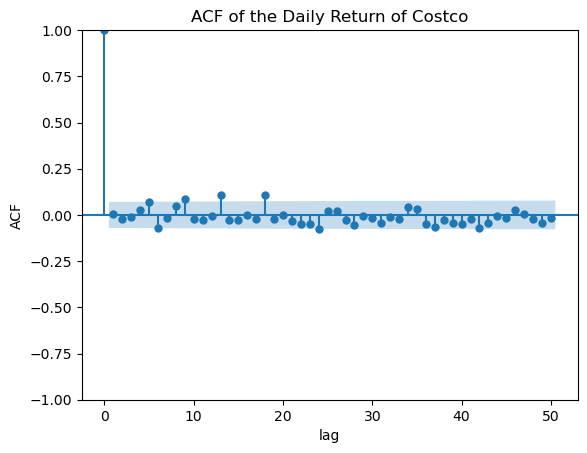

In [8]:
result_acf = acf(r)

plot_acf(r,lags = 50)
plt.xlabel("lag")
plt.ylabel("ACF")
plt.title("ACF of the Daily Return of Costco")
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

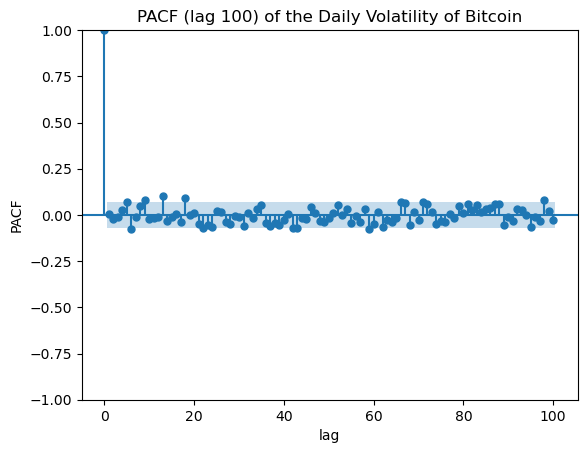

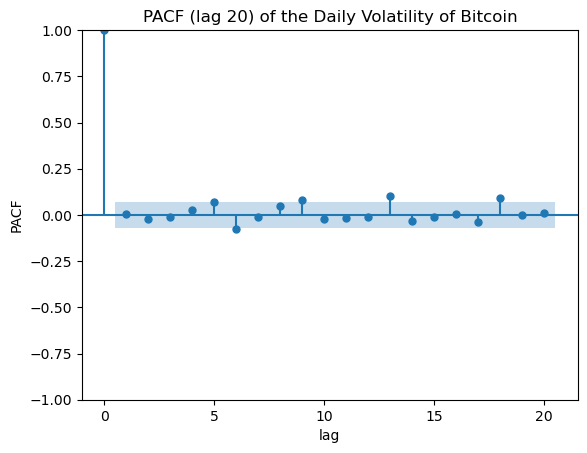

In [9]:
result_pacf = pacf(r)


plot_pacf(r,lags = 100)
plt.xlabel("lag")
plt.ylabel("PACF")
plt.title("PACF (lag 100) of the Daily Volatility of Bitcoin")
plt.show

plot_pacf(r,lags = 20)
plt.xlabel("lag")
plt.ylabel("PACF")
plt.title("PACF (lag 20) of the Daily Volatility of Bitcoin")
plt.show

Lag>1 dropped arund zero => AR patter catched => AR models applicable

## ARIMA Model

Since the data is already stationary，no need to diff the data. Thus, d=0

In [10]:
n = split_point
m = len(r)-n

In [11]:
# To prevent the overfitting problem, we set the range on 11.
p=11
q=11
mse_arma=np.zeros((p,q))

for i in range(p):
    for j in range(q):
        model = ARIMA(train_r, order=(i,0,j))
        model_fit = model.fit()
        forecasted_r_arma = model_fit.forecast(m)
        mse_arma[i,j] = mean_squared_error(test_r,forecasted_r_arma)
        
        
np.where(mse_arma == np.amin(mse_arma))

(array([1]), array([8]))

p=1 follows previous result on ACF & PACF

In [12]:
model = ARIMA(train_r, order=(1,0,8)) 
model_fit = model.fit()
forecasted_r_ARMA= model_fit.predict(start=n, end=n+m-1)

In [13]:
# Define the function to get price

def convert_returns_to_prices(last_known_price, predicted_returns):
    prices = [last_known_price]
    for r in predicted_returns:
        new_price = prices[-1] * (1 + r)
        prices.append(new_price)
    
    return prices[1:]  # Exclude the first element which is the last known price

In [14]:
forecasted_p_ARMA = convert_returns_to_prices(train_p.iloc[-1],forecasted_r_ARMA)
mean_squared_error(test_p, forecasted_p_ARMA)

447.36068862862265

In [15]:
# Make the predicted results index with date

from pandas.tseries.offsets import BDay
import pandas as pd

# Define the date range for trading days from April 6, 2023, to November 10, 2023
trading_days = pd.date_range(start='2023-04-06', end='2023-11-10', freq=BDay()).strftime('%Y-%m-%d').tolist()

# Dates to exclude
dates_to_exclude = ['2023-04-07', '2023-05-29', '2023-06-19', '2023-07-04', '2023-09-04']

# Filter out the excluded dates
dates = [date for date in trading_days if date not in dates_to_exclude]


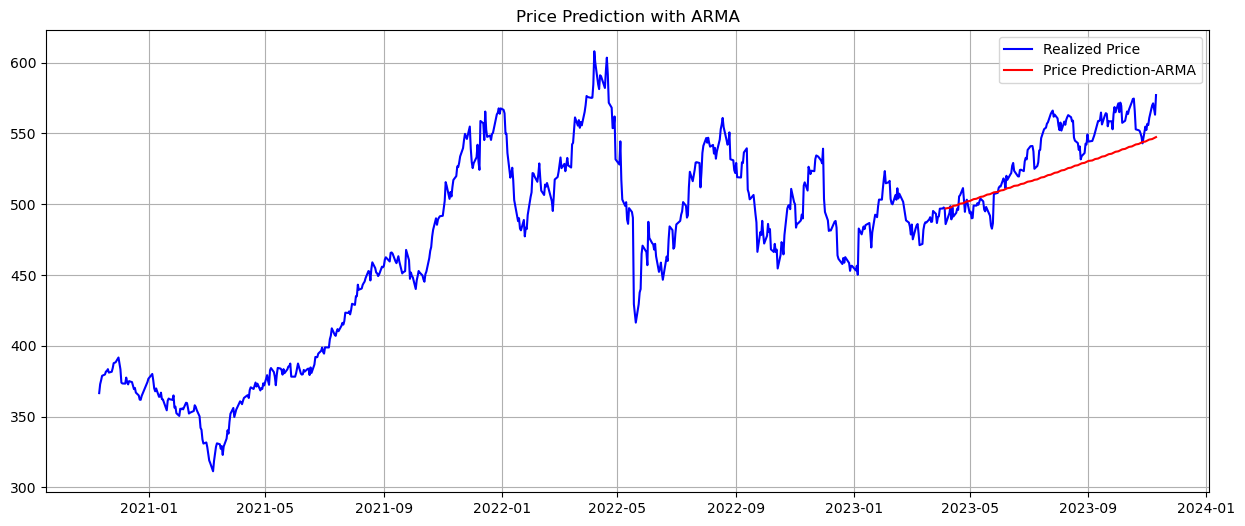

In [16]:
# Draw graphs on testing period
arma=pd.Series(forecasted_p_ARMA,index=pd.to_datetime(dates))
plt.figure(figsize=(15, 6))
plt.plot(price,linestyle='-', color='b', label='Realized Price')
plt.plot(arma,linestyle='-', color='red',label='Price Prediction-ARMA')
plt.title('Price Prediction with ARMA', fontsize=12)
plt.grid(True)
plt.legend()
plt.show()

### Residual Check

In [17]:
residuals_arima = test_p.to_numpy() - forecasted_p_ARMA

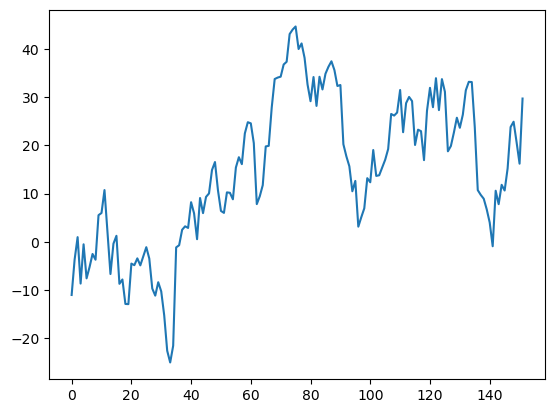

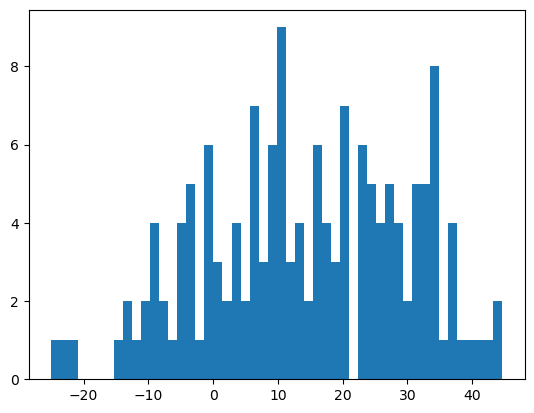

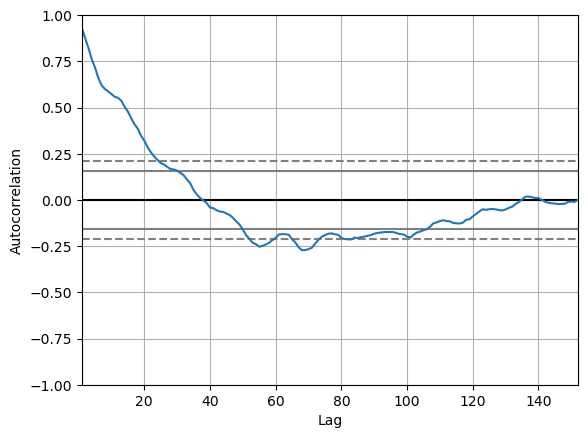

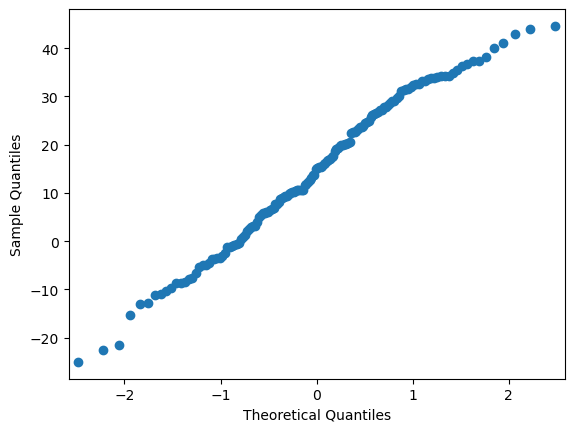

In [18]:
plt.plot(residuals_arima);plt.show()
plt.hist(residuals_arima, bins = 50); plt.show()
autocorrelation_plot(residuals_arima);plt.show()
qqplot(residuals_arima);plt.show()

Residuals look like white noise.

## ARCH Model

### Lag Number

Fist, find the lag number by GARCH(1,1)

In [19]:
p=11
mse_l=np.zeros(p)

for i in range(p):
        model = arch_model(train_r, mean='AR',lags=i, vol='ARCH', p=1, q=1)
        model_fit = model.fit()
        model_fit_forecast = model_fit.forecast(horizon=m)
        forecasted_r_l = model_fit_forecast.mean.values[-1, :]
        mse_l[i] = mean_squared_error(test_r,forecasted_r_l)
        
np.where(mse_l == np.amin(mse_l))

Iteration:      1,   Func. Count:      5,   Neg. LLF: 1274531843.928207
Iteration:      2,   Func. Count:     16,   Neg. LLF: -1197.9058624004597
Iteration:      3,   Func. Count:     23,   Neg. LLF: -1648.9057080995412
Iteration:      4,   Func. Count:     29,   Neg. LLF: -1650.4806606359025
Iteration:      5,   Func. Count:     34,   Neg. LLF: 4878.455543386707
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1651.3575484546232
            Iterations: 5
            Function evaluations: 38
            Gradient evaluations: 5
Iteration:      1,   Func. Count:      6,   Neg. LLF: 4157071026104399.5
Iteration:      2,   Func. Count:     18,   Neg. LLF: -62.244456640272006
Iteration:      3,   Func. Count:     26,   Neg. LLF: -837.6304734991887
Iteration:      4,   Func. Count:     34,   Neg. LLF: -1647.4032375767183
Iteration:      5,   Func. Count:     40,   Neg. LLF: -1624.2196218662798
Iteration:      6,   Func. Count:     48,   Neg. LLF: -16

(array([3]),)

By mse, lag =3

In [20]:
# Use AIC and BIC
def find_best_lag_aic_bic(train_data, max_lags):
    best_aic = np.inf
    best_bic = np.inf
    best_lag_aic = 0
    best_lag_bic = 0
    
    # Loop over possible lag values
    for i in range(1, max_lags + 1):
        # Fit the GARCH model
        model = arch_model(train_data, vol='Garch', p=i, q=i)
        model_fit = model.fit(disp='off')  # disp='off' to silence optimizer output
        
        # Compare AIC/BIC and update best values
        if model_fit.aic < best_aic:
            best_aic = model_fit.aic
            best_lag_aic = i
            
        if model_fit.bic < best_bic:
            best_bic = model_fit.bic
            best_lag_bic = i
    
    return best_lag_aic, best_aic, best_lag_bic, best_bic

find_best_lag_aic_bic(train_r, 11)

(1, -3377.9838693528964, 1, -3360.369572561157)

AIC & BIC suggest using lags = 1.

Also, earlier ACF & PACF state lags =1

mse suggested 3; the others suggested 1 =>用1

### GARCH Model

In [21]:
def select_garch_model(train_data, test_data, max_p, max_q):
    best_mse = np.inf
    best_model = None

    for p in range(1, max_p + 1):
        for q in range(1, max_q + 1):
            # Fit the GARCH model
            model = arch_model(train_data, lags=1,vol='Garch', p=p, q=q)
            model_fit = model.fit(disp='off')
            
            # Forecast
            forecast = model_fit.forecast(horizon=len(test_data))
            predicted_variance = forecast.variance.values[-1, :]

            # Calculate MSE and compare
            mse = mean_squared_error(test_data, predicted_variance)
            if mse < best_mse:
                best_mse = mse
                best_model = (p, q)

    return best_model

In [22]:
select_garch_model(train_r, test_r, 11, 11)

/Users/yuezhao/anaconda3/lib/python3.11/site-packages/arch/univariate/base.py:766: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


(6, 11)

In [23]:
garch_model = arch_model(train_r, mean='AR',lags=1, vol='GARCH', p=6, q=11)
garch_model_fit = garch_model.fit()
garch_model_fit_forecast = garch_model_fit.forecast(horizon=m)
forecasted_r_GARCH = garch_model_fit_forecast.mean.values[-1, :]
forecasted_p_GARCH = convert_returns_to_prices(train_p.iloc[-1],forecasted_r_GARCH)
mean_squared_error(test_p, forecasted_p_GARCH)

Iteration:      1,   Func. Count:     22,   Neg. LLF: 48048785210.55961
Iteration:      2,   Func. Count:     50,   Neg. LLF: 5900.476654833799
Iteration:      3,   Func. Count:     76,   Neg. LLF: 1921836135.5622103
Iteration:      4,   Func. Count:    104,   Neg. LLF: 213877517.59563506
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1687.4280529938828
            Iterations: 6
            Function evaluations: 113
            Gradient evaluations: 4


196.49835754642012

In [24]:
garch=pd.Series(forecasted_p_GARCH,index=pd.to_datetime(dates))
garch

2023-04-06    497.664856
2023-04-10    498.216755
2023-04-11    498.769505
2023-04-12    499.322873
2023-04-13    499.876854
                 ...    
2023-11-06    585.770043
2023-11-07    586.419934
2023-11-08    587.070546
2023-11-09    587.721880
2023-11-10    588.373937
Length: 152, dtype: float64

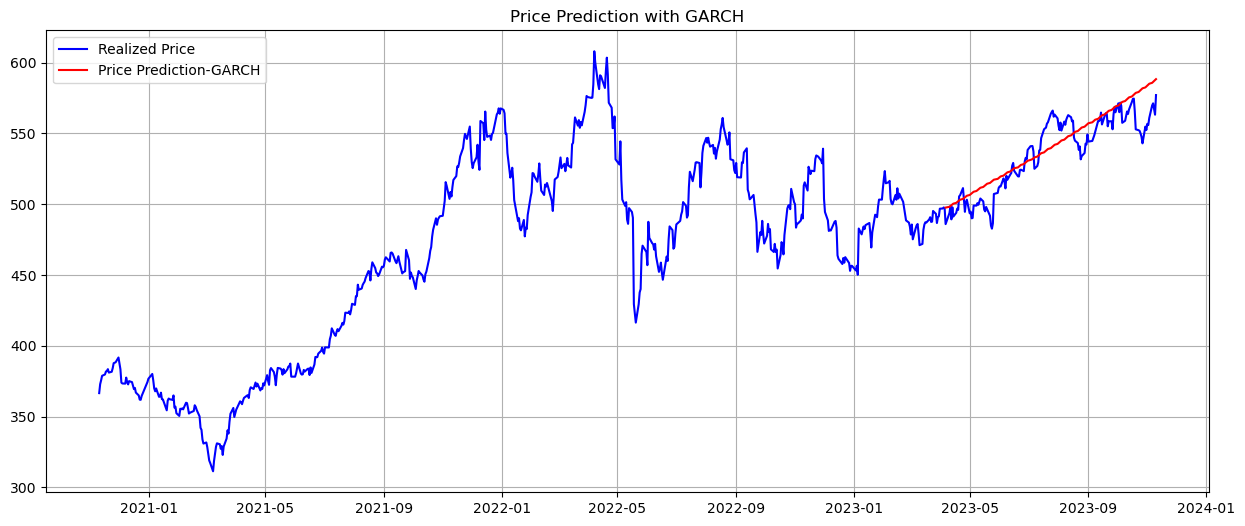

In [25]:
plt.figure(figsize=(15, 6))
plt.plot(price,linestyle='-', color='b', label='Realized Price')
plt.plot(garch,linestyle='-', color='red',label='Price Prediction-GARCH')
plt.title('Price Prediction with GARCH', fontsize=12)
plt.grid(True)
plt.legend()
plt.show()

### Residuals

In [26]:
residuals_garch= test_p.to_numpy() - forecasted_p_GARCH

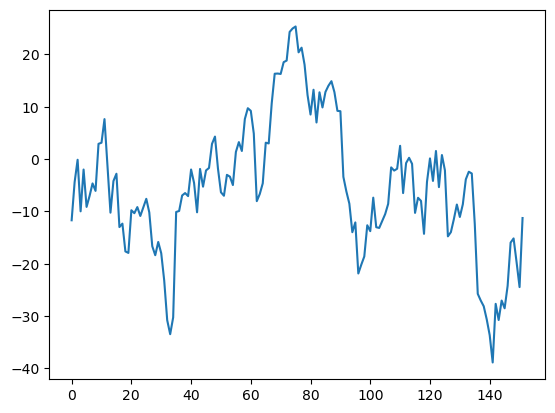

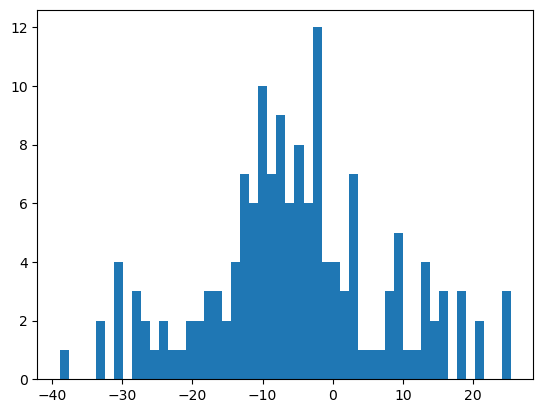

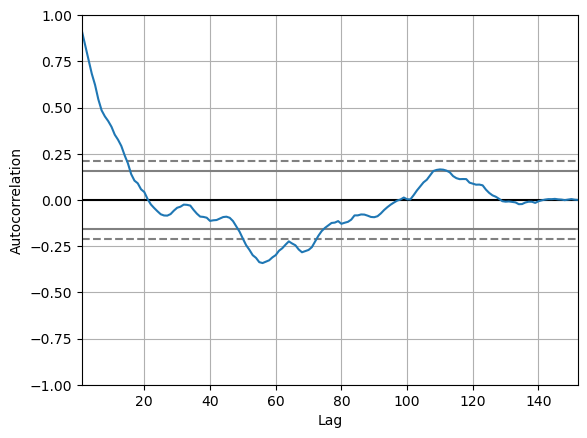

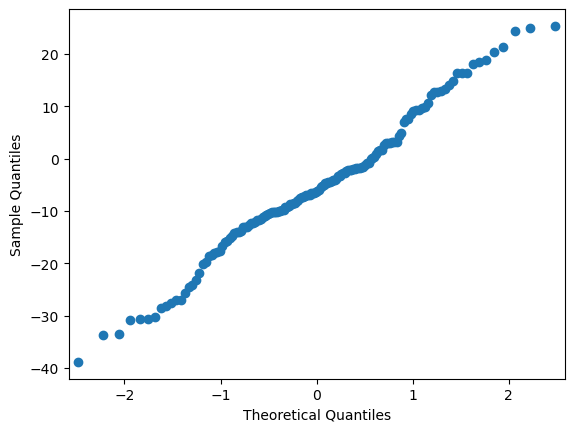

In [27]:
plt.plot(residuals_garch);plt.show()
plt.hist(residuals_garch, bins = 50); plt.show()
autocorrelation_plot(residuals_garch);plt.show()
qqplot(residuals_garch);plt.show()

The residuals appear to look like white noise mostly.

# Machine Leanring Models

## Random Forest

In [28]:
n=51
r=51
mse_rf=np.zeros((n,r))

for i in range(1,n):
    for j in range(1,r):
        model = RandomForestRegressor(n_estimators=i, random_state=j)
        model.fit(X_train, y_train)
        forecasted_r_rf = model.predict(X_test)
        mse_rf[i,j]=mean_squared_error(y_test, forecasted_r_rf)
        
mse_rf

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.00027507, 0.00019607, ..., 0.0002031 , 0.00031923,
        0.0001811 ],
       [0.        , 0.00021119, 0.00015948, ..., 0.0001668 , 0.00026663,
        0.00012608],
       ...,
       [0.        , 0.00012184, 0.00012153, ..., 0.00012077, 0.00012307,
        0.00011782],
       [0.        , 0.00012204, 0.00012147, ..., 0.00012054, 0.00012314,
        0.00011807],
       [0.        , 0.00012204, 0.00012187, ..., 0.00012048, 0.00012248,
        0.00011795]])

In [29]:
mse_rf_1 = np.delete(mse_rf, 0, axis=0)
mse_rf_1 = np.delete(mse_rf_1, 0, axis=1)
np.where(mse_rf == np.amin(mse_rf_1))

(array([4]), array([50]))

In [30]:
#Try this smallest-mse RF model
rf_model = RandomForestRegressor(n_estimators=4, random_state=50)
rf_model.fit(X_train, y_train)
forecasted_r_RF = rf_model.predict(X_test)

In [31]:
forecasted_p_RF = convert_returns_to_prices(train_p.iloc[-1],forecasted_r_RF)
mse_RF = mean_squared_error(test_p, forecasted_p_RF)
mse_RF

4269.471345271701

In [32]:
rf=pd.Series(forecasted_p_RF,index=pd.to_datetime(dates))
rf

2023-04-06    501.544491
2023-04-10    502.576792
2023-04-11    502.091686
2023-04-12    505.501146
2023-04-13    502.324274
                 ...    
2023-11-06    470.953745
2023-11-07    462.219010
2023-11-08    468.291264
2023-11-09    464.471376
2023-11-10    467.361847
Length: 152, dtype: float64

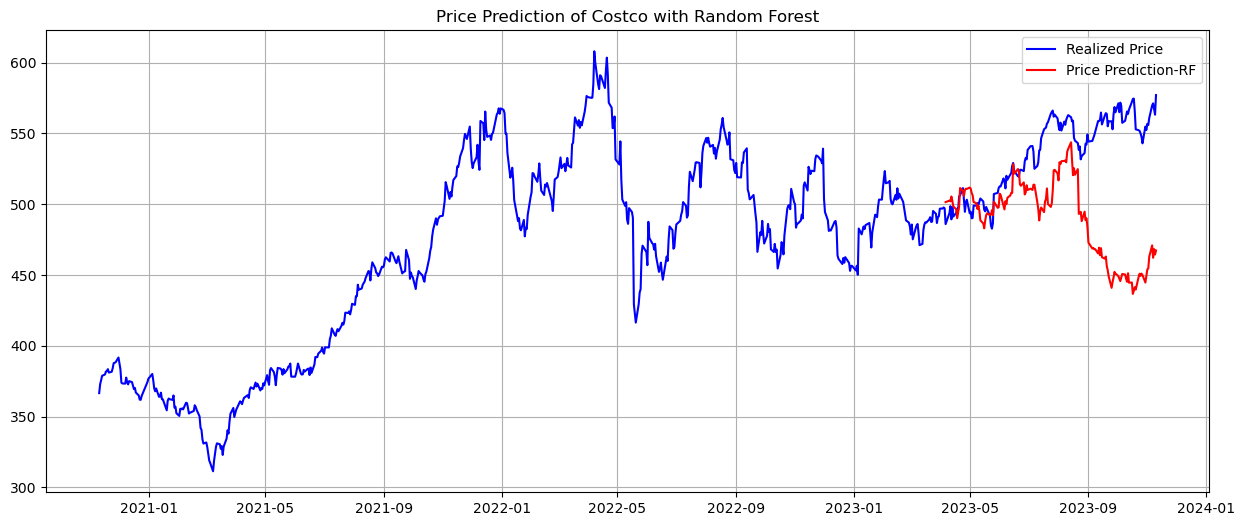

In [33]:
plt.figure(figsize=(15, 6))
plt.plot(price,linestyle='-', color='b', label='Realized Price')
plt.plot(rf,linestyle='-', color='red',label='Price Prediction-RF')
plt.title('Price Prediction of Costco with Random Forest', fontsize=12)
plt.grid(True)
plt.legend()
plt.show()

### Residuals

In [34]:
residuals_rf = test_p.to_numpy() - forecasted_p_RF

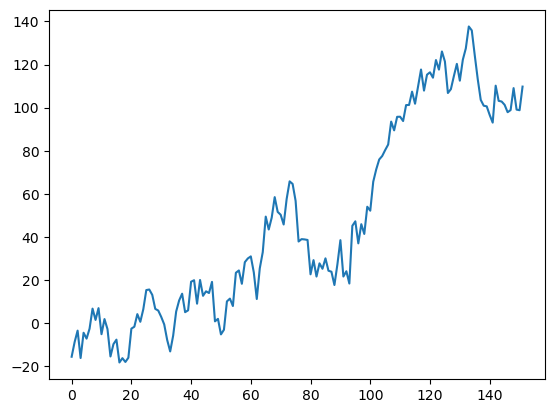

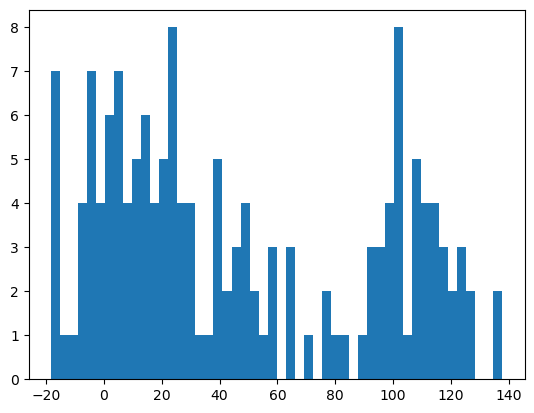

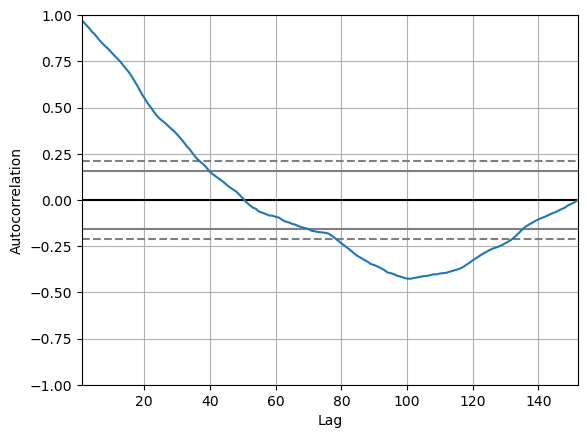

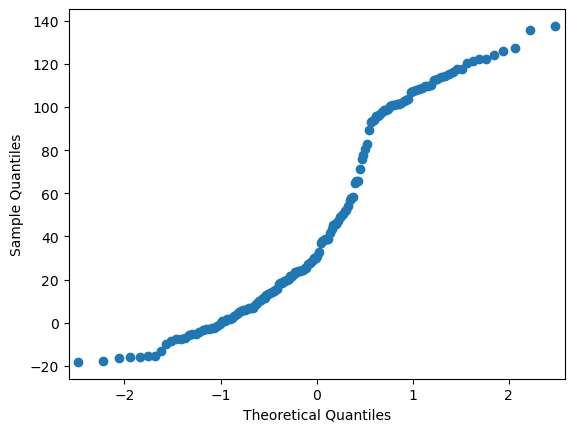

In [35]:
plt.plot(residuals_rf);plt.show()
plt.hist(residuals_rf, bins = 50); plt.show()
autocorrelation_plot(residuals_rf);plt.show()
qqplot(residuals_rf);plt.show()

This doesn't look white noise. This may be beacuse RF caputured too many noise as the important analyzed data, or overfitted the data. Additionally, due to its randomness, it is possible for RF model to compute outfitting results.

## kNN Model

### Simple kNN

In [36]:
r=605
mse_knn=np.zeros(r)

for i in range(1,r):
    model = KNeighborsRegressor(n_neighbors=i)
    model.fit(X_train, y_train)
    forecasted_r_knn = model.predict(X_test)
    mse_knn[i] = mean_squared_error(y_test, forecasted_r_knn)


In [46]:
mse_knn_1=np.delete(mse_knn, np.s_[:1], 0)

In [47]:
np.where(mse_knn == np.amin(mse_knn_1))

(array([163]),)

In [48]:
knn_model = KNeighborsRegressor(n_neighbors= 163)
knn_model.fit(X_train, y_train)
forecasted_r_kNN = knn_model.predict(X_test)
forecasted_p_kNN = convert_returns_to_prices(train_p.iloc[-1],forecasted_r_kNN)
mse_kNN = mean_squared_error(test_p, forecasted_p_kNN)
mse_kNN

167.75773371002265

In [49]:
knn=pd.Series(forecasted_p_kNN,index=pd.to_datetime(dates))
knn

2023-04-06    500.622138
2023-04-10    499.479488
2023-04-11    501.041199
2023-04-12    502.535798
2023-04-13    501.955906
                 ...    
2023-11-06    573.392029
2023-11-07    568.154589
2023-11-08    571.572505
2023-11-09    570.133186
2023-11-10    574.746660
Length: 152, dtype: float64

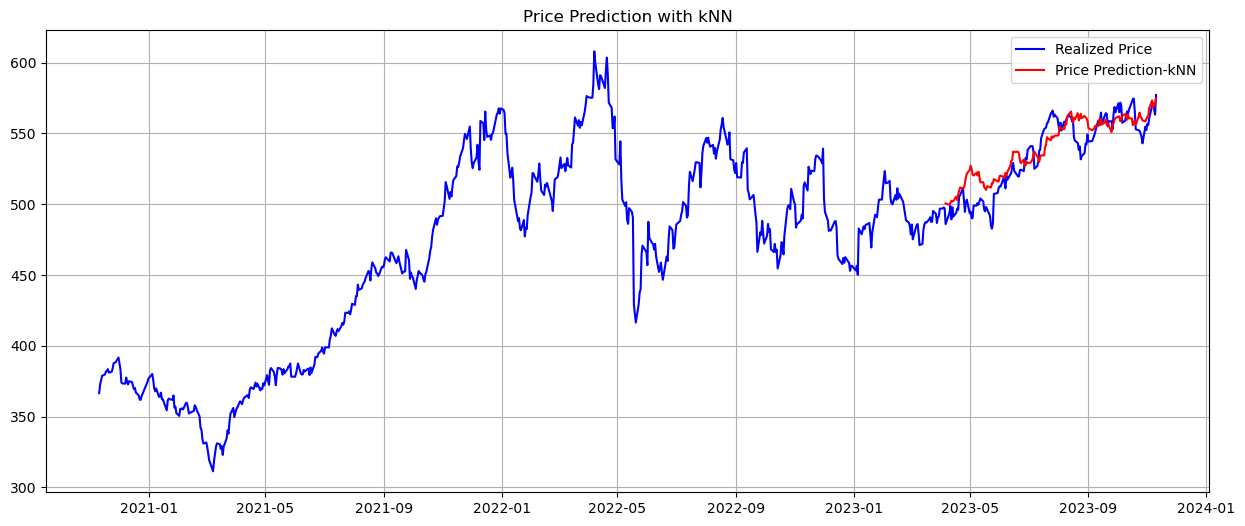

In [50]:
plt.figure(figsize=(15, 6))
plt.plot(price,linestyle='-', color='b', label='Realized Price')
plt.plot(knn,linestyle='-', color='red',label='Price Prediction-kNN')
plt.title('Price Prediction with kNN', fontsize=12)
plt.grid(True)
plt.legend()
plt.show()

### GridSearch

In [51]:
from sklearn.model_selection import GridSearchCV
parameters = {"n_neighbors": range(1, 605)}
gridsearch = GridSearchCV(KNeighborsRegressor(), parameters)
gridsearch.fit(X_train, y_train)

GridSearchCV(estimator=KNeighborsRegressor(),
             param_grid={'n_neighbors': range(1, 605)})

In [52]:
gridsearch.best_params_

{'n_neighbors': 17}

In [53]:
test_preds_grid = gridsearch.predict(X_test)


In [54]:
forecasted_p_kNN_k = convert_returns_to_prices(train_p.iloc[-1],test_preds_grid)
mse_kNN_k = mean_squared_error(test_p, forecasted_p_kNN_k)
mse_kNN_k

1079.4283045802106

### GSCV with weights

In [55]:
parameters = {"n_neighbors": range(1, 605), "weights": ["uniform", "distance"],}
gridsearch = GridSearchCV(KNeighborsRegressor(), parameters)
gridsearch.fit(X_train, y_train)
print(gridsearch.best_params_)

{'n_neighbors': 20, 'weights': 'distance'}


In [56]:
test_preds_grid = gridsearch.predict(X_test)
forecasted_p_kNN_w = convert_returns_to_prices(train_p.iloc[-1],test_preds_grid)
mse_kNN_w = mean_squared_error(test_p, forecasted_p_kNN_w)
mse_kNN_w

1045.1848816329912

In Summary, Simple kNN perform the best

### Residuals

In [57]:
residuals_knn = test_p.to_numpy() - forecasted_p_kNN

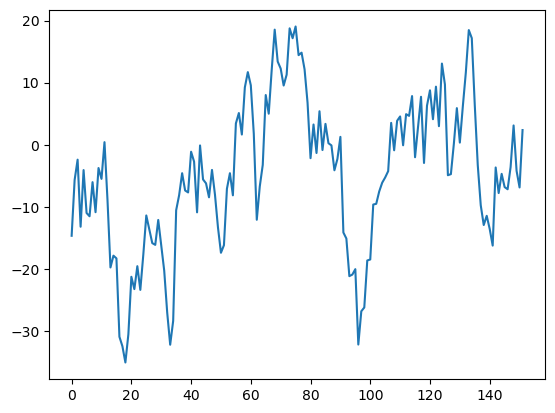

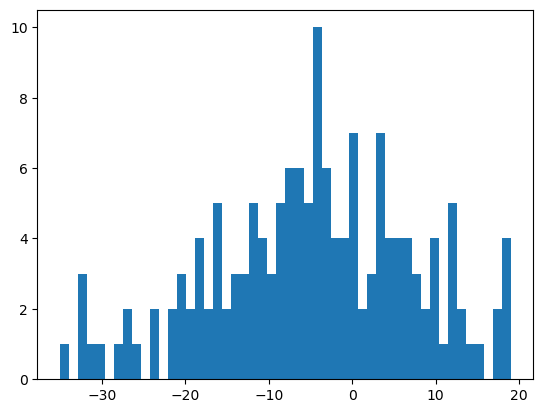

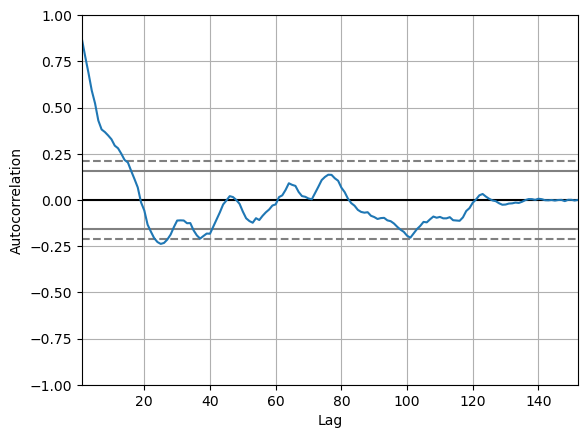

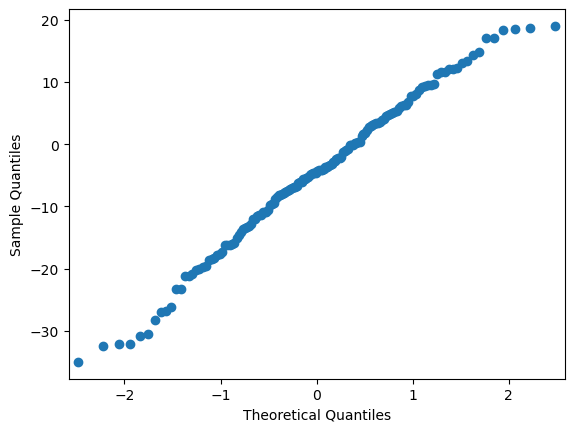

In [58]:
plt.plot(residuals_knn);plt.show()
plt.hist(residuals_knn, bins = 50); plt.show()
autocorrelation_plot(residuals_knn);plt.show()
qqplot(residuals_knn);plt.show()

Residuals look like whit noise

## Support Vector Machine Models

### Linear Kernel

In [59]:
model_SVM_linear = SVR(kernel = 'linear')
model_SVM_linear.fit(X_train, y_train)

SVR(kernel='linear')

In [60]:
forecasted_r_SVM_linear=model_SVM_linear.predict(X_test)

In [61]:
forecasted_p_SVM= convert_returns_to_prices(train_p.iloc[-1],forecasted_r_SVM_linear)
mse_SVM_l = mean_squared_error(test_p, forecasted_p_SVM)
mse_SVM_l

195142.44255169836

From the observation, we can easily find that the return is not growing linearly. The result has proved that.

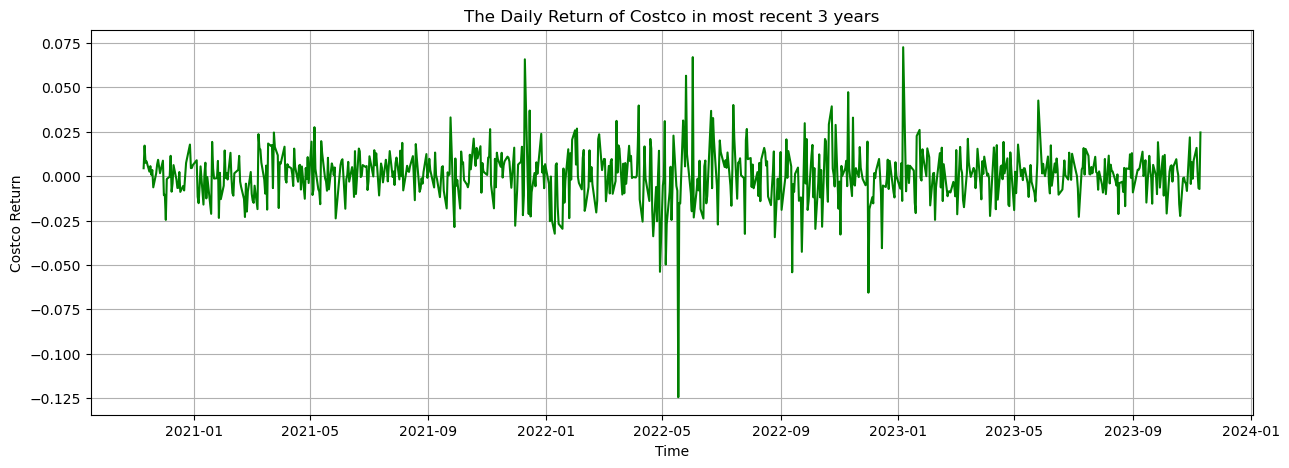

In [62]:
# Return Graph

plt.figure(figsize=(15,5))
plt.plot(df["Return"], linestyle='-', color='g')
plt.xlabel('Time')
plt.ylabel('Costco Return')
plt.title('The Daily Return of Costco in most recent 3 years')
plt.grid(True)
plt.show()

### Polynomial Kernal

In [63]:
model_SVM_p = SVR(kernel = 'poly')
model_SVM_p.fit(X_train, y_train)
forecasted_r_SVM_p=model_SVM_p.predict(X_test)
forecasted_p_SVM_p= convert_returns_to_prices(train_p.iloc[-1],forecasted_r_SVM_p)
mse_SVM_p = mean_squared_error(test_p, forecasted_p_SVM_p)
mse_SVM_p


195142.44255169836

### RBF Kernel

In [64]:
model_SVM_rbf = SVR(kernel = 'rbf')
model_SVM_rbf.fit(X_train, y_train)
forecasted_r_SVM_rbf=model_SVM_rbf.predict(X_test)
forecasted_p_SVM_rbf= convert_returns_to_prices(train_p.iloc[-1],forecasted_r_SVM_rbf)
mse_SVM_rbf = mean_squared_error(test_p, forecasted_p_SVM_rbf)
mse_SVM_rbf


195142.44255169836

It is super weird that all three different kernels give all the same result and such a terrifying mse. It even doesn't need analyzing residuals as it is absolutely abnormal. Tried many times to fix it but it doesn't work. Thus, we just give up SVM models.

## Gradient Boosting Model

In [65]:
import pandas as pd
from sklearn.ensemble import GradientBoostingRegressor  # or GradientBoostingRegressor for regression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, mean_squared_error 

### Basic GB

In [66]:
gb_reg = GradientBoostingRegressor()
gb_reg.fit(X_train, y_train)
predictions = gb_reg.predict(X_test)
forecasted_p_G= convert_returns_to_prices(train_p.iloc[-1],predictions)
mse_G = mean_squared_error(test_p, forecasted_p_G)
mse_G

992.0004473480667

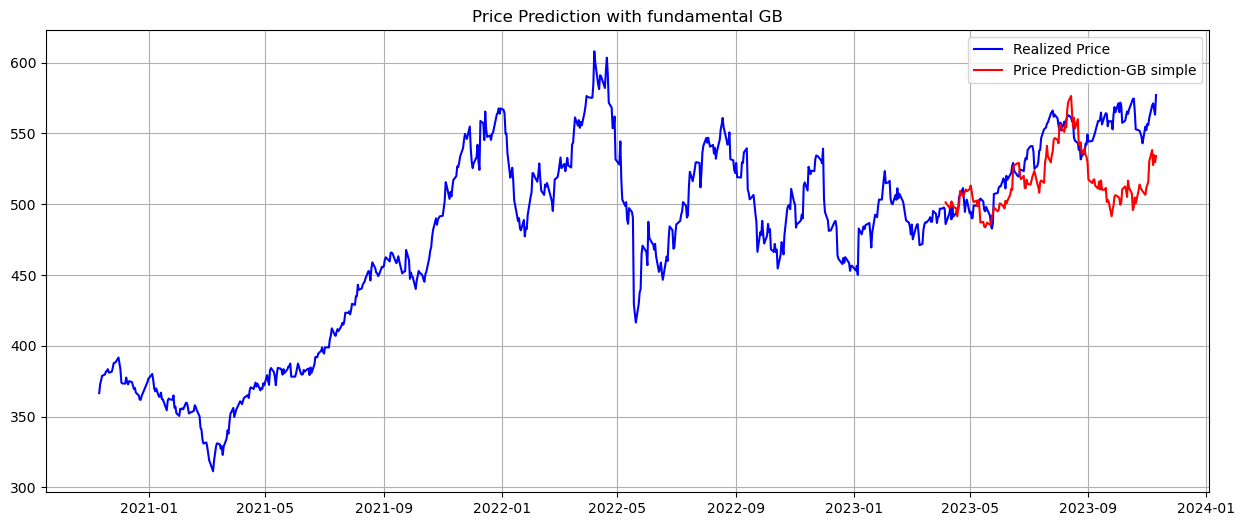

In [67]:
g=pd.Series(forecasted_p_G,index=pd.to_datetime(dates))
plt.figure(figsize=(15, 6))
plt.plot(price,linestyle='-', color='b', label='Realized Price')
plt.plot(g,linestyle='-', color='red',label='Price Prediction-GB simple')
plt.title('Price Prediction with fundamental GB', fontsize=12)
plt.grid(True)
plt.legend()
plt.show()

### GSCV to select parameters

Tried to run GSCV in ranges, but that's too much and needed one day to compute. Thus, we select some important and common parameter values and find the best-fit combinations.

In [68]:
param_grid = {
    'n_estimators': [50,100,150,200,250,300,350,400,450,500,550,600],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'min_samples_split': [2, 4],
    'min_samples_leaf': [1, 2],
    # You can include other parameters here
}

gb_model = GradientBoostingRegressor()
grid_search = GridSearchCV(gb_model, param_grid, cv=5, scoring='neg_mean_squared_error')

In [69]:
grid_search.fit(X_train, y_train)
print("Best Parameters:", grid_search.best_params_)

Best Parameters: {'learning_rate': 0.01, 'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 400}


In [73]:
# Create the model with the best parameters
gb_reg = GradientBoostingRegressor(
    n_estimators=400,
    learning_rate=0.01,
    max_depth=3,
    min_samples_split=2,
    min_samples_leaf=1,
    random_state=42
)

# Fit the model to the training data
gb_reg.fit(X_train, y_train)


GradientBoostingRegressor(learning_rate=0.01, n_estimators=400, random_state=42)

In [74]:
predictions = gb_reg.predict(X_test)
forecasted_p_GB= convert_returns_to_prices(train_p.iloc[-1],predictions)
mse_GB = mean_squared_error(test_p, forecasted_p_GB)
mse_GB

1070.8593692458794

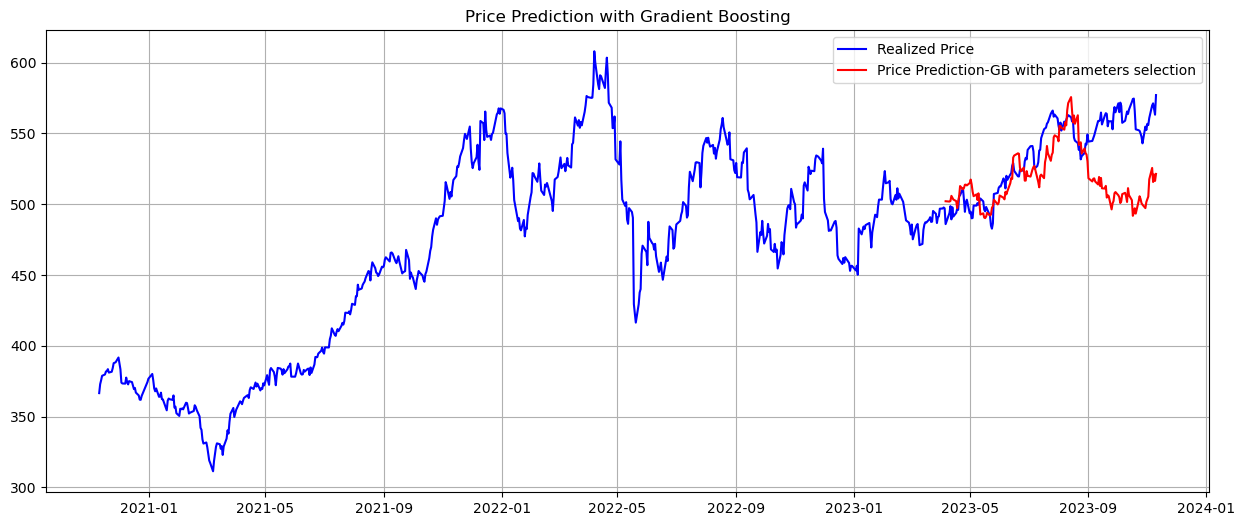

In [76]:
gb=pd.Series(forecasted_p_GB,index=pd.to_datetime(dates))
plt.figure(figsize=(15, 6))
plt.plot(price,linestyle='-', color='b', label='Realized Price')
plt.plot(gb,linestyle='-', color='red',label='Price Prediction-GB with parameters selection')
plt.title('Price Prediction with Gradient Boosting', fontsize=12)
plt.grid(True)
plt.legend()
plt.show()

# Final Prediction

Compare all the mse values we computed, we find GARCH(6,11) the best one to make predictions

In [77]:
k=80

In [86]:
garch_model = arch_model(df['Return'], mean='AR',lags=1, vol='GARCH', p=6, q=11)
garch_model_fit = garch_model.fit()

Iteration:      1,   Func. Count:     22,   Neg. LLF: 62212838110.13025
Iteration:      2,   Func. Count:     50,   Neg. LLF: 31164.304638732363
Iteration:      3,   Func. Count:     76,   Neg. LLF: 5538149.801700717
Iteration:      4,   Func. Count:    104,   Neg. LLF: 55300938.573809005
Iteration:      5,   Func. Count:    132,   Neg. LLF: 6136223.440701903
Iteration:      6,   Func. Count:    160,   Neg. LLF: 2238344.594597297
Iteration:      7,   Func. Count:    188,   Neg. LLF: 6864552.338009913
Iteration:      8,   Func. Count:    217,   Neg. LLF: 17075.445242951162
Iteration:      9,   Func. Count:    243,   Neg. LLF: 97090450.67812519
Iteration:     10,   Func. Count:    270,   Neg. LLF: -2166.2503709487537
Optimization terminated successfully    (Exit mode 0)
            Current function value: -2166.2503697368343
            Iterations: 14
            Function evaluations: 270
            Gradient evaluations: 10


In [89]:
# Substitue the price on 10th Nov directly.

garch_model_fit_forecast = garch_model_fit.forecast(horizon=k)
forecasted_return = garch_model_fit_forecast.mean.values[-1, :]
forecasted_price = convert_returns_to_prices(577.119995,forecasted_return)

In [90]:
trading_days_p = pd.date_range(start='2023-11-11', end='2024-03-01', freq=BDay()).strftime('%Y-%m-%d').tolist()

# Filter out the excluded dates
dates_p = [date for date in trading_days_p]
final_p=pd.Series(forecasted_price,index=pd.to_datetime(dates_p))
final_p

2023-11-13    577.836602
2023-11-14    578.485305
2023-11-15    579.134385
2023-11-16    579.784192
2023-11-17    580.434727
                 ...    
2024-02-26    628.538248
2024-02-27    629.243487
2024-02-28    629.949518
2024-02-29    630.656341
2024-03-01    631.363957
Length: 80, dtype: float64

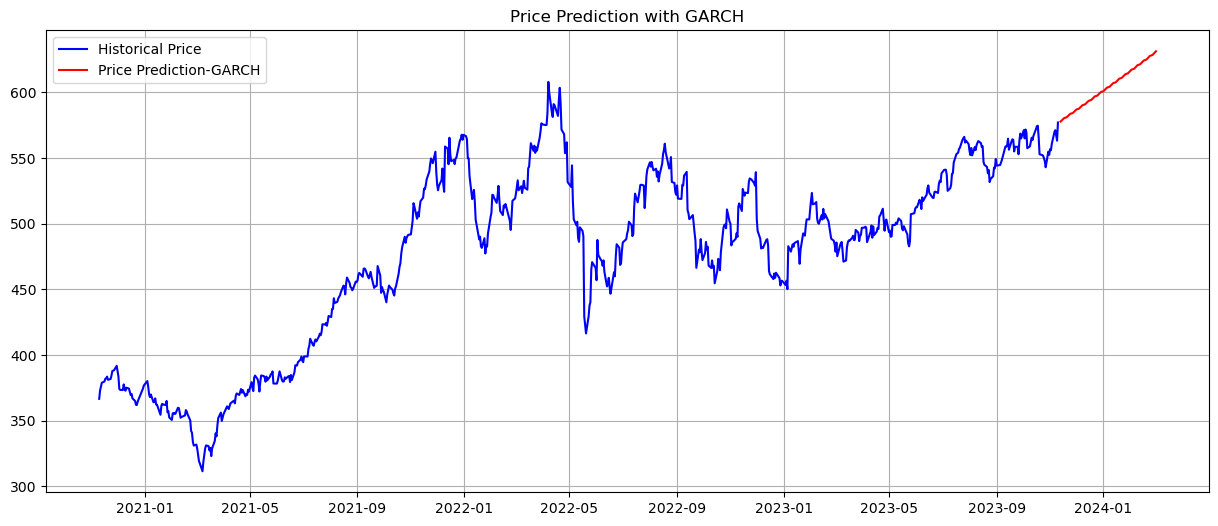

In [91]:
plt.figure(figsize=(15, 6))
plt.plot(price,linestyle='-', color='b', label='Historical Price')
plt.plot(final_p,linestyle='-', color='red',label='Price Prediction-GARCH')
plt.title('Price Prediction with GARCH', fontsize=12)
plt.grid(True)
plt.legend()
plt.show()